# Calculating Ignition Delay Time (In Progress)
*Daniel I Pineda, James L Urban, and Carlos Fernandez-Pello*, 2017

### Ignition Delay Time
In this example, we go over the concept of ignition delay time, defined here as the time it takes for a combustible mixture to increase in temperature by 400 K. Different fuels display different ignition behavior depending on the temperature, pressure, and equivalence ratio. Unlike adiabatic flame temperature, chemical reactions and chemical reaction rates are relevant here; a chemical mechanism is a "map of possible pathways" from reactants to products. This code has been adapted from an [example reactor code](http://www.cantera.org/docs/sphinx/html/cython/examples/reactors_reactor1.html), along with another [example code for sensitivity analysis](http://www.cantera.org/docs/sphinx/html/cython/examples/reactors_sensitivity1.html) available at the Cantera website. 

### Import Packages
- [cantera](http://www.cantera.org/docs/sphinx/html/index.html): A Combustion Chemistry Python Module 
    - Chemical Equilibrium
    - 1-D Flame Speed
    - Surface Chemistry
- [numpy](http://www.numpy.org/): A Mathematical Function Libary (similiar functions to MATLAB) 
    - Linear Algegra
    - Root Finding
    - Simple Data Analysis
- [matplotlib](http://matplotlib.org/): A Python Figure making and Plotting Software 

In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Intitialize Gas Object
For this example we will initialize a gas object ("`igGas`") using the [GRI-MECH 3.0 mechanism](http://combustion.berkeley.edu/gri-mech/version30/text30.html), which is a chemical kinetic mechanism optimized for natural gas combustion. 

In [2]:
igGas = ct.Solution('gri30.xml')

### Set Initial Gas Mixture and Conditions
As a first example, we will first examine a mixture of methane and oxygen in argon with the following conditions:
- Composition: Stoichiometric methane ($CH_4$) and oxygen ($O_2$) with argon ($Ar$) as the bath gas. Ignition delay experiments are often carried out in an inert bath gas to isolate specific reactions and better examine the kinetics. 
- $T = 1500~K$
- $P = 101.325~kPa$

In [3]:
Tinit_ig = 1500 # Kelvin
Pinit_ig = 101325 # Pascals
igGas.TPX = Tinit_ig, Pinit_ig, "CH4:3.3,O2:6.7,AR:90"

### Set up a reactor object and reactor network
In Cantera, there are [different classes of zero-dimensional reactors depending on the system conditions you want to simulate](http://www.cantera.org/docs/sphinx/html/cython/zerodim.html). These reactors keep track of the temperature, pressure, species mole fractions, and other conditions inside of them. They can have surfaces, inlets and outlets, and moveable walls. For this example, we assume an adiabatic constant pressure reactor with an ideal gas equation of state.

Reactors can be placed in reactor networks on their own or with other reactors, and these networks can be advanced in time to run kinetics simulations.  

We initialize the reactor `igReactor` with the `igGas` we previously initialized in the last step, and we place `igReactor` in the reactor network `igReactorNetwork`. 

In [4]:
igReactor = ct.IdealGasConstPressureReactor(igGas)
igReactorNetwork = ct.ReactorNet([igReactor])

### Enable sensitivity analysis of reactions during the simulation

Often in combustion experiments, we measure concentrations of different species in time and then use this information to help figure out which reactions must be most relevant to the production of that species. This information is particularly useful for building and optimizing kinetic mechanisms, because the rates of many reactions are not yet known with satisfactory accuracy, and sometimes experimentalists can only measure certain species with the equipment available to them. 

In this example, we'll look at CO, CO2, and OH, which [are all species that can be measured in one way or another](http://www.spectraplot.com/absorption), and we'll look at some reactions of interest, some of which don't include the species at all. When sensitivity analysis is enabled for specific reactions, as we will do here, Cantera will perturb the rate of that reaction and determine the influence of that perturbation on the concentration of the species we are interested in. If we find that the concentration of CO (something we can measure) is very sensitive to a specific reaction (something we can't always measure directly), we may want to investigate that reaction more closely to make sure its rate constants are accurate or consistent with our experiments. 

In [5]:
# enable sensitivity with respect to the rates of some selected reations
igReactor.add_sensitivity_reaction(31) # R32: O2 + CH2O <=> HO2 + HCO
igReactor.add_sensitivity_reaction(37) # R38: H + O2 <=> O + OH (often considered the most important reaction in combustion) 
igReactor.add_sensitivity_reaction(118) # R119: HO2 + CH3 <=> OH + CH3O
igReactor.add_sensitivity_reaction(157) # R158: 2 CH3 (+ M) <=> C2H6 (+ M)
igReactor.add_sensitivity_reaction(158) # R159: 2 CH3 <=> H + C2H5

# set the tolerances for the solution and for the sensitivity coefficients
igReactorNetwork.rtol = 1.0e-6
igReactorNetwork.atol = 1.0e-15
igReactorNetwork.rtol_sensitivity = 1.0e-6
igReactorNetwork.atol_sensitivity = 1.0e-6

### Set up simulation parameters

Here, we specify some variables to keep track of `igReactorNetwork` and species mole fractions as we advance the simulation time. We initialize `time` at `0.0` seconds and specify the maximum number of steps we want the simulation to take with `numSteps`. Then we initialize the variable `igStates` to keep track of the simulation time, temperature, and select species concentrations for all of these steps through the `SolutionArray` function of Cantera. Additionally, we will create variables within the `SolutionArray` object to keep track of the sensitivity analysis as a function of time. Lastly, we initialize the variable where ignition delay time will be stored, `tIgn` as zero. 

In [6]:
time = 0.0
numSteps = 100000
igStates = ct.SolutionArray(igGas, extra=['t', 's32_CO', 's38_CO', 's119_CO', 's158_CO', 's159_CO', \
                                          's32_CO2', 's38_CO2', 's119_CO2', 's158_CO2', 's159_CO2', \
                                          's32_OH', 's38_OH', 's119_OH', 's158_OH', 's159_OH'])
tIgn = 0

### Advance the simulation in a `for` loop
Here, we advance the simualtion according to a fixed time step of `1.e-7` and use the `advance` function of the `ReactorNet` class to do so. At each timestep, the simulation time, temperature, and species mole fractions are recorded into the variable `igStates` that we initialized in the last step. Every timestep, we check to see if the reactor temperature has increased by 400 K. If it has, we change the assignment of `tIgn` to a value other than zero. Thanks to the equality check in the conditional statement, `tIgn` will not be overwritten in subsequent timesteps. Finally, we add a conditional statement that is printed if the 400 K treashold is not achieved. 

In [7]:
for n in range(numSteps):
    time += 1.e-7
    igReactorNetwork.advance(time)
    
    s32_CO = igReactorNetwork.sensitivity('CO', 0)
    s38_CO = igReactorNetwork.sensitivity('CO', 1)
    s119_CO = igReactorNetwork.sensitivity('CO', 2)
    s158_CO = igReactorNetwork.sensitivity('CO', 3)
    s159_CO = igReactorNetwork.sensitivity('CO', 4)
    
    s32_CO2 = igReactorNetwork.sensitivity('CO2', 0)
    s38_CO2 = igReactorNetwork.sensitivity('CO2', 1)
    s119_CO2 = igReactorNetwork.sensitivity('CO2', 2)
    s158_CO2 = igReactorNetwork.sensitivity('CO2', 3)
    s159_CO2 = igReactorNetwork.sensitivity('CO2', 4)
    
    s32_OH = igReactorNetwork.sensitivity('OH', 0)
    s38_OH = igReactorNetwork.sensitivity('OH', 1)
    s119_OH = igReactorNetwork.sensitivity('OH', 2)
    s158_OH = igReactorNetwork.sensitivity('OH', 3)
    s159_OH = igReactorNetwork.sensitivity('OH', 4)
    
    igStates.append(igReactor.thermo.state, t=time*1e3, \
                    s32_CO = s32_CO, s38_CO = s38_CO, s119_CO = s119_CO, s158_CO = s158_CO, s159_CO = s159_CO, \
                    s32_CO2 = s32_CO2, s38_CO2 = s38_CO2, s119_CO2 = s119_CO2, s158_CO2 = s158_CO2, s159_CO2 = s159_CO2, \
                    s32_OH = s32_OH, s38_OH = s38_OH, s119_OH = s119_OH, s158_OH = s158_OH, s159_OH = s159_OH)
    if ((igReactor.T - Tinit_ig) > 400) and (tIgn == 0): # check to see if temperature has increased by 400 K
        tIgn = time*1e3 
        print("Calculated Ignition Delay is = " + str(tIgn) + " ms")
    if ((time == 1.e-7*numSteps) and (tIgn == 0)):
        print("Mixture did not ignite in the simulation time alotted.")

Calculated Ignition Delay is = 3.2449 ms


### Plot the mole fraction results
In this step, we use `matplotlb` to create a plot of species and temperature over time. For each species plot, we attach a label for later use in the legend. After labeling the axes, we use `matplotlib`'s [Axes.twinx method](https://matplotlib.org/examples/api/two_scales.html) to create a second y-axes for the temperature. 

<IPython.core.display.Javascript object>


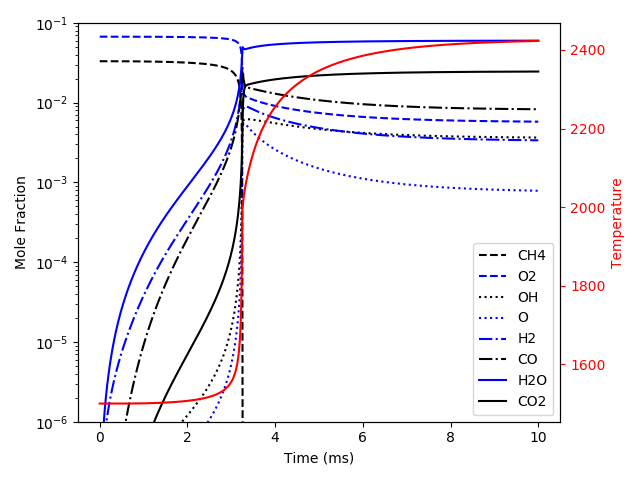

In [8]:
fig, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig'

# now, plot the species mole fractions as a function of time:
ax1.plot(igStates.t, igStates.X[:,igGas.species_index('CH4')], 'k--', label='CH4')
ax1.plot(igStates.t, igStates.X[:,igGas.species_index('O2')], 'b--', label='O2')
ax1.plot(igStates.t, igStates.X[:,igGas.species_index('OH')], 'k:', label='OH')
ax1.plot(igStates.t, igStates.X[:,igGas.species_index('O')], 'b:', label='O')
ax1.plot(igStates.t, igStates.X[:,igGas.species_index('H2')], 'b-.', label='H2')
ax1.plot(igStates.t, igStates.X[:,igGas.species_index('CO')], 'k-.', label='CO')
ax1.plot(igStates.t, igStates.X[:,igGas.species_index('H2O')], 'b-', label='H2O')
ax1.plot(igStates.t, igStates.X[:,igGas.species_index('CO2')], 'k-', label='CO2')

# label the axis and scale it on a log scale:
ax1.set_ylabel('Mole Fraction', color='k')
ax1.set_xlabel('Time (ms)')
ax1.tick_params('y', colors='k')
ax1.set_yscale('log')
plt.ylim((1E-6,0.1)) # set a bounds so that near-zero mole fractions are not plotted

# now, plot the temperature in the reactor as a function of time
ax2 = ax1.twinx()
ax2.plot(igStates.t, igStates.T, 'r-')
ax2.set_ylabel('Temperature', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot


### Plot Sensitivity Analysis Results

Now, we'll plot the sensitivities of our measured species to the different reactions. First, let's look at CO. 

<IPython.core.display.Javascript object>


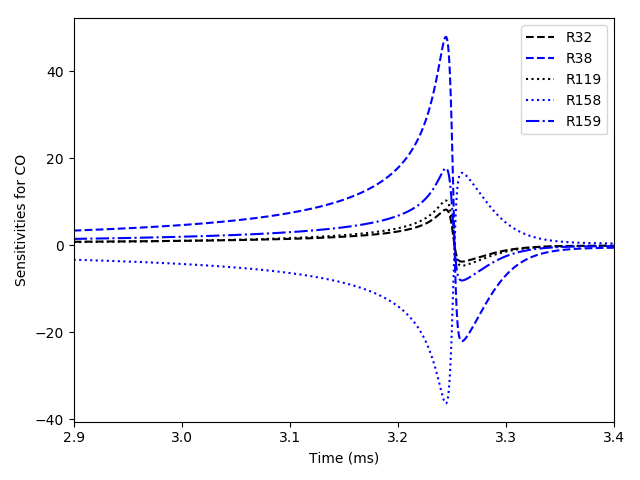

In [9]:
fig1, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig1'

# now, plot the species mole fractions as a function of time:
ax1.plot(igStates.t, igStates.s32_CO, 'k--', label='R32')
ax1.plot(igStates.t, igStates.s38_CO, 'b--', label='R38')
ax1.plot(igStates.t, igStates.s119_CO, 'k:', label='R119')
ax1.plot(igStates.t, igStates.s158_CO, 'b:', label='R158')
ax1.plot(igStates.t, igStates.s159_CO, 'b-.', label='R159')

# label the axes
ax1.set_ylabel('Sensitivities for CO', color='k')
ax1.set_xlabel('Time (ms)')
ax1.tick_params('y', colors='k')
plt.xlim((2.9, 3.4)) # set a bounds to zoom into a region of interest

fig1.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot

It seems that the concentration of CO is most sensitive to reaction 38, H + O2 <=> O + OH. This is consistent with the general consensus that this reaction is often considered the most important reaction in combustion. One of the reasons for this is that it is a chain branching reaction, in which one radical generates two radicals through a reaction. That the sensitivity value is positive for this reaction leading up to ignition indicates that if the rate of reaction 38 increases, the concentration of CO increases as well. 

The concentration of CO is next most sensitive to reaction 158, 2 CH3 (+ M) <=> C2H6 (+ M). The fact that this sensitivity value is negative leading up to ignition indicates that if the rate of reaction 158 is increased, then the concentration of CO decreases. This also implies that if the rate of reaction 158 decreases, then the concentration of CO increases. One of the reasons this reaction is inhibitive to the production of CO is that it is a chain terminating reaction, in which two radicals combine to form a stable species. Thus, for a short period of time, the carbon that would otherwise go into CO is locked up inside C2H6. 

Of the reactions we investigated, the concentration of CO is least sensitive to reaction 32 for these conditions. 

An interesting thing to note is that, during ignition, many of the sensitivities change sign for CO. For example, this means that if the rate of reaction 38 increases, then the concentration of CO decreases. This tells us that---at this point during the combustion process---the products of reaction 38 (O and OH) likely attack CO to convert it into CO2. Leading up to ignition, howevever, O and OH are preferentially attacking other species and producing CO in the process. This highlights the role of CO as a stable intermediate---it is first produced before it is consumed.

Now, let's look at CO2. 

<IPython.core.display.Javascript object>


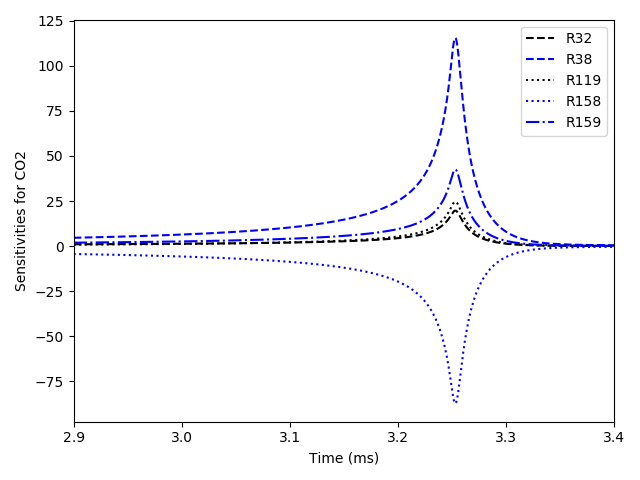

In [10]:
fig2, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig2'

# now, plot the species mole fractions as a function of time:
ax1.plot(igStates.t, igStates.s32_CO2, 'k--', label='R32')
ax1.plot(igStates.t, igStates.s38_CO2, 'b--', label='R38')
ax1.plot(igStates.t, igStates.s119_CO2, 'k:', label='R119')
ax1.plot(igStates.t, igStates.s158_CO2, 'b:', label='R158')
ax1.plot(igStates.t, igStates.s159_CO2, 'b-.', label='R159')

# label the axes
ax1.set_ylabel('Sensitivities for CO2', color='k')
ax1.set_xlabel('Time (ms)')
ax1.tick_params('y', colors='k')
plt.xlim((2.9, 3.4)) # set a bounds to zoom into a region of interest

fig2.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot

Like CO, CO2 is most sensitive to reactions 38 and 158, for much of the same reasons. Unlike CO, the sensitivities of CO do not flip sign throughout the ignition process. This highlights the role of CO2 as a stable combustion product. Once formed, it does not typically react with anything else. However, this criterion alone is not enough to consider a species to be a stable product, as is demonstrated by looking at the sensitivity analyses with regards to OH below. 

<IPython.core.display.Javascript object>


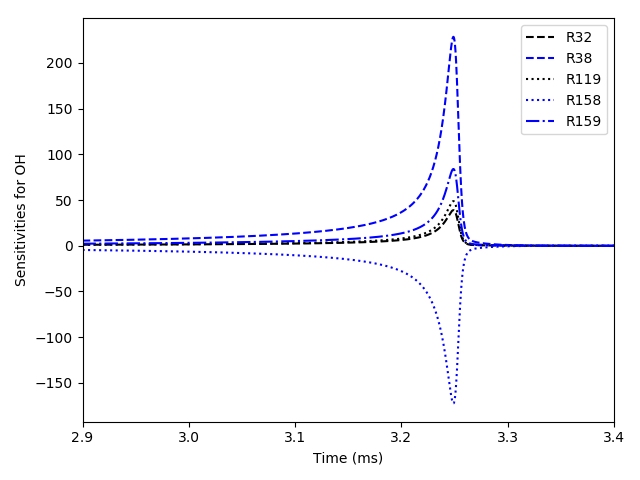

In [11]:
fig3, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig3'

# now, plot the species mole fractions as a function of time:
ax1.plot(igStates.t, igStates.s32_OH, 'k--', label='R32')
ax1.plot(igStates.t, igStates.s38_OH, 'b--', label='R38')
ax1.plot(igStates.t, igStates.s119_OH, 'k:', label='R119')
ax1.plot(igStates.t, igStates.s158_OH, 'b:', label='R158')
ax1.plot(igStates.t, igStates.s159_OH, 'b-.', label='R159')

# label the axes
ax1.set_ylabel('Sensitivities for OH', color='k')
ax1.set_xlabel('Time (ms)')
ax1.tick_params('y', colors='k')
plt.xlim((2.9, 3.4)) # set a bounds to zoom into a region of interest

fig3.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot

Altering the rate of reaction 38 substantially alters the concentration of OH, which is not surprising since OH is a product of reaction 38. Like CO and CO2, reaction 158 locks up hydrogen that could otherwise be in OH into C2H6, and these chain-terminating reactions are in general an inhibitor for the generation of additional OH. The rapid approach to zero during the ignition process indicates that the reactions are no longer relevant to the production and destruction of OH. 

### The influence of pressure

Let's re-run the simulation and analysis again at 10 atmospheres to see the effect of pressure on the ignition process:

Calculated Ignition Delay is = 0.6054 ms


<IPython.core.display.Javascript object>


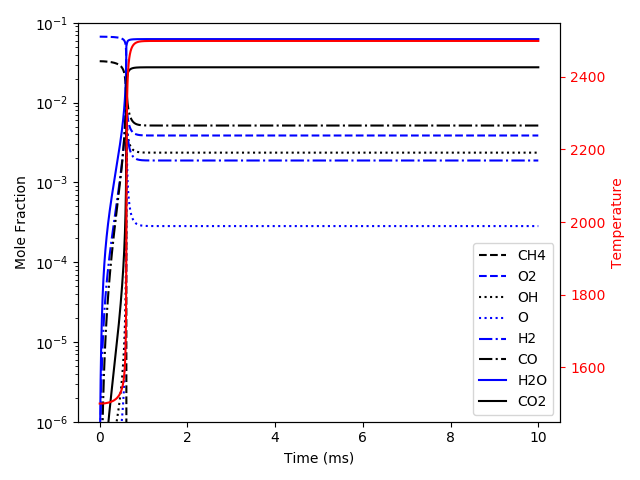

In [12]:
igGas2 = ct.Solution('gri30.xml')

Tinit_ig2 = 1500 # Kelvin
Pinit_ig2 = 10*101325 # Pascals
igGas2.TPX = Tinit_ig2, Pinit_ig2, "CH4:3.3,O2:6.7,AR:90"

igReactor2 = ct.IdealGasConstPressureReactor(igGas2)
igReactorNetwork2 = ct.ReactorNet([igReactor2])

# enable sensitivity with respect to the rates of some selected reations
igReactor2.add_sensitivity_reaction(31) # R32: O2 + CH2O <=> HO2 + HCO
igReactor2.add_sensitivity_reaction(37) # R38: H + O2 <=> O + OH (often considered the most important reaction in combustion) 
igReactor2.add_sensitivity_reaction(118) # R119: HO2 + CH3 <=> OH + CH3O
igReactor2.add_sensitivity_reaction(157) # R158: 2 CH3 (+ M) <=> C2H6 (+ M)
igReactor2.add_sensitivity_reaction(158) # R159: 2 CH3 <=> H + C2H5

# set the tolerances for the solution and for the sensitivity coefficients
igReactorNetwork2.rtol = 1.0e-6
igReactorNetwork2.atol = 1.0e-15
igReactorNetwork2.rtol_sensitivity = 1.0e-6
igReactorNetwork2.atol_sensitivity = 1.0e-6

time2 = 0.0
numSteps2 = 100000
igStates2 = ct.SolutionArray(igGas2, extra=['t', 's32_CO', 's38_CO', 's119_CO', 's158_CO', 's159_CO', \
                                          's32_CO2', 's38_CO2', 's119_CO2', 's158_CO2', 's159_CO2', \
                                          's32_OH', 's38_OH', 's119_OH', 's158_OH', 's159_OH'])
tIgn2 = 0

for n in range(numSteps2):
    time2 += 1.e-7
    igReactorNetwork2.advance(time2)
    
    s32_CO = igReactorNetwork2.sensitivity('CO', 0)
    s38_CO = igReactorNetwork2.sensitivity('CO', 1)
    s119_CO = igReactorNetwork2.sensitivity('CO', 2)
    s158_CO = igReactorNetwork2.sensitivity('CO', 3)
    s159_CO = igReactorNetwork2.sensitivity('CO', 4)
    
    s32_CO2 = igReactorNetwork2.sensitivity('CO2', 0)
    s38_CO2 = igReactorNetwork2.sensitivity('CO2', 1)
    s119_CO2 = igReactorNetwork2.sensitivity('CO2', 2)
    s158_CO2 = igReactorNetwork2.sensitivity('CO2', 3)
    s159_CO2 = igReactorNetwork2.sensitivity('CO2', 4)
    
    s32_OH = igReactorNetwork2.sensitivity('OH', 0)
    s38_OH = igReactorNetwork2.sensitivity('OH', 1)
    s119_OH = igReactorNetwork2.sensitivity('OH', 2)
    s158_OH = igReactorNetwork2.sensitivity('OH', 3)
    s159_OH = igReactorNetwork2.sensitivity('OH', 4)
    
    igStates2.append(igReactor2.thermo.state, t=time2*1e3, \
                    s32_CO = s32_CO, s38_CO = s38_CO, s119_CO = s119_CO, s158_CO = s158_CO, s159_CO = s159_CO, \
                    s32_CO2 = s32_CO2, s38_CO2 = s38_CO2, s119_CO2 = s119_CO2, s158_CO2 = s158_CO2, s159_CO2 = s159_CO2, \
                    s32_OH = s32_OH, s38_OH = s38_OH, s119_OH = s119_OH, s158_OH = s158_OH, s159_OH = s159_OH)
    if ((igReactor2.T - Tinit_ig2) > 400) and (tIgn2 == 0): # check to see if temperature has increased by 400 K
        tIgn2 = time2*1e3 
        print("Calculated Ignition Delay is = " + str(tIgn2) + " ms")
    if ((time2 == 1.e-7*numSteps2) and (tIgn2 == 0)):
        print("Mixture did not ignite in the simulation time alotted.")
        
fig, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig'

# now, plot the species mole fractions as a function of time:
ax1.plot(igStates2.t, igStates2.X[:,igGas2.species_index('CH4')], 'k--', label='CH4')
ax1.plot(igStates2.t, igStates2.X[:,igGas2.species_index('O2')], 'b--', label='O2')
ax1.plot(igStates2.t, igStates2.X[:,igGas2.species_index('OH')], 'k:', label='OH')
ax1.plot(igStates2.t, igStates2.X[:,igGas2.species_index('O')], 'b:', label='O')
ax1.plot(igStates2.t, igStates2.X[:,igGas2.species_index('H2')], 'b-.', label='H2')
ax1.plot(igStates2.t, igStates2.X[:,igGas2.species_index('CO')], 'k-.', label='CO')
ax1.plot(igStates2.t, igStates2.X[:,igGas2.species_index('H2O')], 'b-', label='H2O')
ax1.plot(igStates2.t, igStates2.X[:,igGas2.species_index('CO2')], 'k-', label='CO2')

# label the axis and scale it on a log scale:
ax1.set_ylabel('Mole Fraction', color='k')
ax1.set_xlabel('Time (ms)')
ax1.tick_params('y', colors='k')
ax1.set_yscale('log')
plt.ylim((1E-6,0.1)) # set a bounds so that near-zero mole fractions are not plotted

# now, plot the temperature in the reactor as a function of time
ax2 = ax1.twinx()
ax2.plot(igStates2.t, igStates2.T, 'r-')
ax2.set_ylabel('Temperature', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot

Immediately, we can see that the time to ignition has decreased substantially as the pressure has increased. This generally makes sense; molecular collisions are more frequent at higher pressures, and so in general, reactions proceed more rapidly. However, not all reactions are affected in the same way. As before, we'll start with CO:

<IPython.core.display.Javascript object>


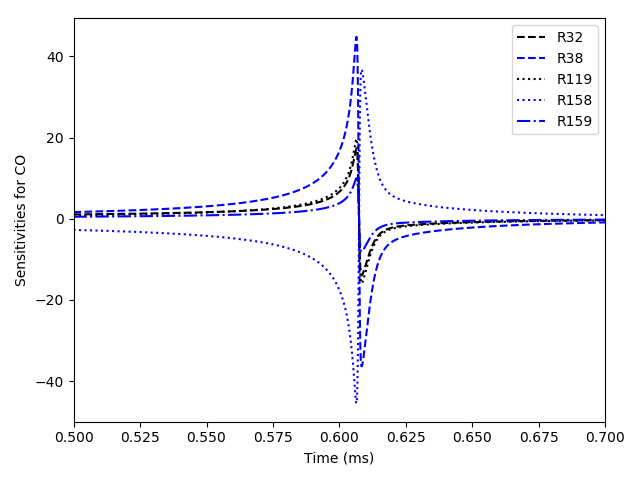

In [13]:
fig1, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig1'

# now, plot the species mole fractions as a function of time:
ax1.plot(igStates2.t, igStates2.s32_CO, 'k--', label='R32')
ax1.plot(igStates2.t, igStates2.s38_CO, 'b--', label='R38')
ax1.plot(igStates2.t, igStates2.s119_CO, 'k:', label='R119')
ax1.plot(igStates2.t, igStates2.s158_CO, 'b:', label='R158')
ax1.plot(igStates2.t, igStates2.s159_CO, 'b-.', label='R159')

# label the axes
ax1.set_ylabel('Sensitivities for CO', color='k')
ax1.set_xlabel('Time (ms)')
ax1.tick_params('y', colors='k')
plt.xlim((0.5, 0.7)) # set a bounds to zoom into a region of interest

fig1.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot

The concentration of CO is now most sensitive to reaction 158 rather than reaction 38, though not by much. Additionally, reaction 32 is no longer the least influentual reaction. These reactions involve three-body collisions, designated by the +M in the equations of the reactions. These reactions increase in importance relative to two-body collisions as the pressure increases. The story is similar for CO2, as shown below: 

<IPython.core.display.Javascript object>


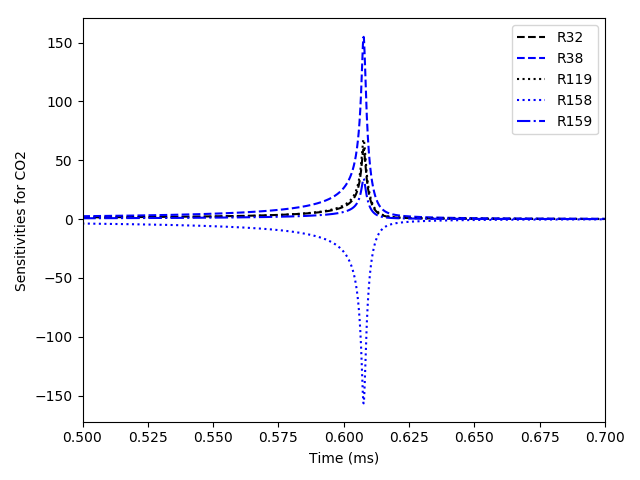

In [14]:
fig2, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig2'

# now, plot the species mole fractions as a function of time:
ax1.plot(igStates2.t, igStates2.s32_CO2, 'k--', label='R32')
ax1.plot(igStates2.t, igStates2.s38_CO2, 'b--', label='R38')
ax1.plot(igStates2.t, igStates2.s119_CO2, 'k:', label='R119')
ax1.plot(igStates2.t, igStates2.s158_CO2, 'b:', label='R158')
ax1.plot(igStates2.t, igStates2.s159_CO2, 'b-.', label='R159')

# label the axes
ax1.set_ylabel('Sensitivities for CO2', color='k')
ax1.set_xlabel('Time (ms)')
ax1.tick_params('y', colors='k')
plt.xlim((0.5, 0.7)) # set a bounds to zoom into a region of interest

fig2.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot

The same is true for OH: 

<IPython.core.display.Javascript object>


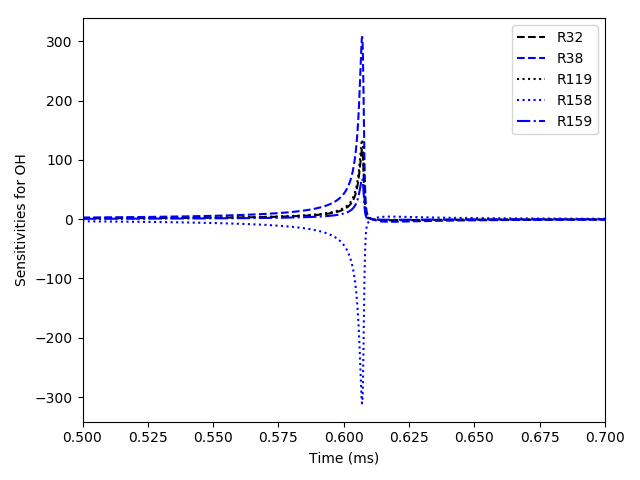

In [15]:
fig3, ax1 = plt.subplots() # intialize a plot on axes 'ax1' in figure 'fig3'

# now, plot the species mole fractions as a function of time:
ax1.plot(igStates2.t, igStates2.s32_OH, 'k--', label='R32')
ax1.plot(igStates2.t, igStates2.s38_OH, 'b--', label='R38')
ax1.plot(igStates2.t, igStates2.s119_OH, 'k:', label='R119')
ax1.plot(igStates2.t, igStates2.s158_OH, 'b:', label='R158')
ax1.plot(igStates2.t, igStates2.s159_OH, 'b-.', label='R159')

# label the axes
ax1.set_ylabel('Sensitivities for OH', color='k')
ax1.set_xlabel('Time (ms)')
ax1.tick_params('y', colors='k')
plt.xlim((0.5, 0.7)) # set a bounds to zoom into a region of interest

fig3.tight_layout()

ax1.legend() # add a legend
plt.show() # display the plot

### Insights gained as a result of sensitivity analysis

If we were to make a measurement of CO, CO2, or OH that disagreed with the model shown here at a specific time during the combustion process, we might wonder what reaction in the model needs adjustment or subsequent investigation. Additionally, if our model agreed at low pressures, but disgareed at high pressures, then we can use sensitivity analysis to help determine whether or not specific three-body reactions are responsible for the disagreement. 

Sensitivity analysis provides a method for identifying these relevant reactions, and proposing new experiments to test new hypotheses. 